# Active sampling code
## Test case using Rastrigin function as objective function

In [1]:
import numpy as np
from datetime import datetime as time
# apply cache/archive in 3D same as 1D
import mystic.cache as mc
import dataset as ds
import mystic.math.legacydata as ld
from mystic.math.interpolate import _unique as unique
import interpolator as itp
from mystic.monitors import Monitor
import dataset as ds
import multiprocess.dummy as mp #FIXME: fails processes
from mystic.monitors import LoggingMonitor
import itertools as it
import dill

### Select solver and searcher algorithms

In [2]:
from mystic.solvers import NelderMeadSimplexSolver as solver
from mystic.samplers import *
searcher = SparsitySampler
#searcher = BuckshotSampler

In [3]:
### Select objective function, number of solvers, and search bound

In [4]:
shape = (2,0) #FIXME: rastrigin

mname = 'demo'  # dynamic 'model' name
fname = 'dirty' # static 'data' name
pname = 'demo'  # hyper_plot name
ename = 'stop'  # termination name

etol = 1 # None # int rounding precision for termination point cache
npts = 4 #2 #500 # number of solvers used in a searcher
upper = 10 #FIXME: 1000  # upper bound on input parameters
bounds = [(0,upper)] * shape[0] # bounds (lower is zero) on input parameters

# objective
if shape[-1]:
    exec('from objective import objective{0} as objective'.format(shape[-1]))
else: # z is single-valued
    from mystic.models import rosen as objective
#     from dca import gstr as objective

In [5]:
# produce objective function that caches multi-valued output
model = mc.cached(archive=mname, multivalued=bool(shape[-1]))(objective)

# get the cache (it stores the full multi-valued tuple)
cache = model.__cache__()

# get "model inverse" (for maximization)
imodel = model.__inverse__

# produce memorization function to cache 'solved' points 
memo = mc.cached(archive=ename, tol=etol, multivalued=bool(shape[-1]))(lambda x, **kwds: kwds['out'])

# get the cache (for solved values)
extrema = memo.__cache__()

def sample(axis=None, invert=False):
    """search (for minima) until terminated
    """#FIXME: {solver:directed or None}, {terminated:all, evals:1000}
    if invert:
        _model = imodel
        l = -1
    else:
        _model = model
        l = 1
    if axis is None:
        model_ = lambda x: _model(x)
    else:
        model_ = lambda x: _model(x, axis)
    s = searcher(bounds, model_, npts=npts, solver=solver)
    #print('sampling...')
    s.sample_until(terminated=all) # npts=4 ==> ~800
    #s.sample_until(terminated=any) # npts=4 ==> ~300
    #s.sample_until(iters=20) # npts=500 -> 1000
    #s.sample_until(evals=1) # npts=500 -> 1000
    #s.sample(reset_all=False)
    #print('done sampling...')
    #NOTE: extract and save last points in the solver (nominally, the extrema)
    if etol is not None: #XXX: use None to turn off caching 'solved' values?
        slv = s._sampler._allSolvers
        for _s in slv:
            memo(_s.bestSolution, out=l*_s.bestEnergy)
    return s

def isample(axis=None):
    """search (for maxima) until terminated
    """#FIXME: {solver:directed or None}, {terminated:all, evals:1000}
    return sample(axis=axis, invert=True)

def _apply(f, arg):
    """call a function f with one argument arg"""
    return f(arg)

def search(axis, **kwds): #FIXME: axis=None, samplers=None
    """search for minima and maxima, until terminated

    Inputs:
      axis: int in [0,N], the axis of z to select
      map: (parallel) map function 
    """ #XXX: other kwds to pass to sample/isample
    _map = kwds.get('map', map)
    fs = (sample, isample) #FIXME: accept list of samplers (don't hardwire)
    return list(_map(_apply, fs, [axis]*len(fs)))

In [6]:
dill.dump(objective, open('cost.pkl', 'wb'))

In [7]:
def valid(dist, max=1e-4, ave=1e-5):
    """True if max(dist) <= max and ave(dist) <= ave
    dist: numpy array of distances of shape (npoints,)
    max: float, largest acceptable distance
    ave: float, largest acceptable average of all distances
    """
    return dist.max() <= max and dist.mean() <= ave

def validate(x, z, axis, data=None, func=None, **kwds):
    """ensure function of (x,z) is valid with respect to all data

    Inputs:
      x: an array of shape (npts, dim) or (npts,)
      z: an array of shape (npts, N) or (npts,)
      axis: int in [0,N], the axis of z to select
      data: a mystic.math.legacydata.dataset of legacy data
      func: interpolated function z = f(*x) for data (x,z)

    Additional Inputs:
      warm: int, search until "warm" samples are taken (default is 0)
      iters: int, abort after iters (default is inf)
      retain: True if retain (x,z) in model cache (default is True)

    Output:
      returns tuple of (interpolated function, trained distance, test distance),
      where trained distances is the graphical distance from the data to the
      trained function, and test distance is the graphical distance from the
      data to 'func' (the original function). If func is None, test distance
      is returned as None.

    NOTE:
      additional keyword arguments are avaiable for interpolation. See
      mystic.math.interpolate.interpf for more details.
    """ # data,func single-valued
    warm = kwds.get('warm', 0)
    iters = kwds.get('iters', float('inf'))
    retain = kwds.get('retain', True)
    _tuple = lambda i: (tuple(i) if shape[-1] else i)
    # get archived model evaluations
    c = model.__cache__()
    #ax = axify(axis)
    # get inital data
    if data is None or data is True: #FIXME: True is easter egg
        _data = ds.from_archive(c, axis=None)
    else:
        _data = ds.from_archive(c, axis=None).load(data.coords, data.values) #XXX: new ids

    # ensure data is "warm" (has desired number of points)
    warm -= 0 if not x else len(unique(x)) #FIXME: x could be in c
    while max(0, warm-len(c)): # while is 'not warm'
        print('warming to {warm}...'.format(warm=warm))
        # launch searchers
        s = sum(s.evals() for s in search(axis)) #XXX: Pool().map?
        print('{a}: evals:{e}, cache:{c}'.format(a=axis,e=s,c=len(c)))

    # include desired points in cache
    if not x:
        pass
    elif retain:
        x,z = unique(x,z)
        x,z = x.tolist(),[_tuple(i) for i in z]
        for xi,zi in zip(x,z):
            c.update({tuple(xi):zi}) #XXX: assumes 'clear' key,value
    elif retain is None: #XXX: retain, but reevaluate z #FIXME: easter egg
        x = unique(x).tolist()
        z = [model(i) for i in x]
    else: # temporarily include (x,z) in data
        x,z = unique(x,z) #XXX: or pass?
        x,z = x.tolist(),[_tuple(i) for i in z]

    # load 'warmed' data from archive
    # add new data points to the data
    if data is None or data is True: #FIXME: True is easter egg
        data = ds.from_archive(c, axis=None)
    else:
        data = ds.from_archive(c, axis=None).load(data.coords, data.values) #XXX: new ids
    if x: data = data.load(x,z) # ids?
    xx,zz = unique(data.coords, data.values)
    data = ld.dataset().load(xx.tolist(),[_tuple(i) for i in zz]) #XXX: new ids
    del xx,zz

    # check for validity of the function
    if func is None:
        dist = np.array([np.inf]) # initialize as False
        repeat = iters
        while not valid(dist) and repeat:
            print('training...')
            # interpolate
            m = Monitor()
            m._x,m._y = data.coords,data.values
            f = itp.Interpolator(m, **kwds).Interpolate(axis=axis)
            # calculate distance/validity
            dist = ds.distance(data, function=f, axis=axis)
            repeat -= 1
        if valid(dist):
            print('train valid: max:{max}, mean:{mean}'.format(max=dist.max(), mean=dist.mean()))
            return f, dist, None
        #NOTE: this code should be reached only very rarely if at all
        print('train invalid: max:{max}, mean:{mean}'.format(max=dist.max(), mean=dist.mean()))
        # launch searchers
        s = sum(s.evals() for s in search(axis)) #XXX: Pool().map?
        print('{a}: evals:{e}, cache:{c}'.format(a=axis,e=s,c=len(c)))
        res = validate(x,z, axis=axis, data=data, func=f, **kwds)
        return res[0], res[1], None #XXX: None or dist?
    else:
        # calculate distance/validity
        print('testing...')
        dist = ds.distance(data, function=func, axis=axis)
        if not valid(dist):
            # recalculate with new function
            print('test invalid: max:{max}, mean:{mean}'.format(max=dist.max(), mean=dist.mean()))
            # get distance to the new data
            _data = data.filter([not i for i in data.has_datapoint(_data)])
            dist = ds.distance(_data, function=func, axis=axis)
            del _data
            #print('new invalid: max:{max}, mean:{mean}'.format(max=dist.max(), mean=dist.mean())) #NOTE: generally should be identical to 'test invalid'
            res = validate(x,z, axis=axis, data=data, func=None, **kwds)
            return res[0], res[1], dist
        print('test valid: max:{max}, mean:{mean}'.format(max=dist.max(), mean=dist.mean()))
        return func, None, dist

In [8]:
print(time.now())
rb = mc.function

2021-06-09 11:31:58.727679


In [9]:
print('no new data points (x,z)')
x,z = [],[]

no new data points (x,z)


In [10]:
# get handles to func_DBs
if shape[-1]:
    archives = list(map(lambda i: rb.db('func{i}.db'.format(i=i)), range(shape[-1])))
else:
    archives = rb.db('func.db')
# check for stored func in func_db, and if not found
# generate a dummy interpf to store results
func = rb.read(archives)

it = 10   # this is number of refit tries before 'fail' to sampling
w = 1000  # this is size of 'warm' #FIXME: rastrigin
y = len(model.__cache__())
w *= (1 + (y // w))  # warm in increments of 'w'

if shape[-1]:
    hist = dict((i,[]) for i in range(shape[-1]))
    warm = [w]*shape[-1]
else:
    hist = {None:[]}
    warm = [w]
size = []

d = [True] # this is data=None or data=True

if shape[-1]:
    do = lambda : (lambda i: d[i])(0)
    xyz = lambda i: validate(x, z, axis=i, data=do(), func=func.__axis__[i], warm=warm[i], method='thin_plate', iters=it) #XXX: epsilon?
else:
    do = lambda : (lambda i: d[0])(0)
    xyz = lambda i: validate(x, z, axis=None, data=do(), func=func, warm=warm[0], method='thin_plate', iters=it) #XXX: epsilon?


def xxx(i):
    # 'validate' a function
    _f,_d,_t = xyz(i)
    # save 'test' distance
    if _t is not None and _d is not None:
        hist[i].append(_t.mean()) #FIXME: mean or max? or sum?
        #hist[i].append(_t.max()) #FIXME: mean or max? or sum?
    # read data from (cached) run archive
    if (shape[-1] and None in func.__axis__) or (func is None):
        print('{i}: no stored function'.format(i=i))
        return (_f,_d,_t)[0]
    if _d is None:
        print('{i}: retain stored function'.format(i=i))
        return (func.__axis__[i],_t)[0] if shape[-1] else (func,_t)[0]

    c = model.__cache__()
    data = ds.from_archive(c, axis=None) #XXX: axis?
    # calculate dist from data to func
    dist = ds.distance(data, function=func, axis=None) #XXX: axis?
    # keep the func with the smaller 'trained' distance
    _d, d = _d.sum(), dist[i].sum()
    if _d < d:
        print('{i}: replace stored function'.format(i=i))
        return (_f,_d,_t)[0]
    print('{i}: retain stored function'.format(i=i))
    return (func.__axis__[i],d,_t)[0] if shape[-1] else (func,d,_t)[0]

pool = mp.Pool()
smap = pool.map
#smap = lambda *args,**kwds: list(map(*args, **kwds))

print('learning in thread-parallel')
null = float('nan')
tol = 2e-4 #FIXME: better than rep iters <= tol, should stop when rep converges #FIXME: rastrigin
rep = 3  #NOTE: this is hist.values()[-rep:] <= tol
last = 3  #NOTE: this is any(size[-last:])
loops = 30 #FIXME: rastrigin
done = False
start = loops


save = LoggingMonitor(1, 'score.txt')

while not done and loops:
    if shape[-1]:
        func.__axis__[:] = smap(xxx, range(shape[-1]))  # data=True, func=None
    else:
        func = smap(xxx, [None])[0]
    rb.write(func, archives)
    # get size of 'terminated' points archive
    size.append(len(mc.archive.read(ename)) - sum(size))
    print('endpoints: {0} of {1}'.format(size[-1], sum(size)))
    # check for 'terminated' stop
    _done = False if last > len(size) else not any(size[-last:])
    # check for 'testing' stop
    done = [hi[-rep:] for hi in hist.values() if len(hi)]
    if not len(done):
        score = float('nan')
        save(warm[:1], score) #NOTE: currently all warm[i] are the same
        print('score: None')
        done = False
    else:
        score = sum([hi[-1] for hi in done])/len(done)
        save(warm[:1], score) #NOTE: currently all warm[i] are the same
        print('score: {mx}'.format(mx=score))
        score = max([max(hi) for hi in done])
        done = False if (len(done) < len(hist)) else score <= tol
    done = _done or done #XXX: or? and?
    if not done:
        for i,wi in enumerate(warm):
            warm[i] = wi + w 
    loops -= 1

pool.close(); pool.join()

# double-checking that final functions are valid

data = ds.from_archive(model.__cache__(), axis=None)
for f in (func.__axis__ if shape[-1] else [func]):
    dist = ds.distance(data, function=f)#, axis=None)
    assert valid(dist)
    print('valid: OK')


learning in thread-parallel
warming to 1000...
None: evals:406, cache:259
warming to 1000...
None: evals:1189, cache:1173
training...
train valid: max:9.758297135846362e-08, mean:5.652665059497484e-09
None: no stored function
endpoints: 7 of 7
score: None
warming to 2000...
None: evals:1190, cache:1938
warming to 2000...
None: evals:1082, cache:2662
testing...
test invalid: max:0.07425814149346043, mean:0.0003234610258696251
training...
train valid: max:3.5136599076759456e-07, mean:1.593918252817434e-08
None: replace stored function
endpoints: 0 of 7
score: 0.0003234610258696251
warming to 3000...
None: evals:1074, cache:3313
testing...
test invalid: max:0.004133231840562761, mean:5.460862491926085e-06
training...
train valid: max:1.574789463262592e-07, mean:1.0520103348893297e-08
None: replace stored function
endpoints: 0 of 7
score: 5.460862491926085e-06
warming to 4000...
None: evals:1179, cache:4050
testing...
test invalid: max:0.033632080586051195, mean:7.028943612959012e-05
train

In [11]:
print('historical testing misfit') #FIXME: mean or max? or sum?
for ii,h in hist.items():
    print('{ii}: {h}'.format(ii=ii, h=np.array(h)))

print('historical endpoint cache size')

historical testing misfit
None: [3.23461026e-04 5.46086249e-06 7.02894361e-05]
historical endpoint cache size


In [12]:
import itertools as it
size[:] = list(it.accumulate(size))
print(size)

[7, 7, 7, 7]


In [13]:
dill.dump(hist, open('hist.pkl', 'wb'))
dill.dump(size, open('size.pkl', 'wb'))
print(time.now())

2021-06-09 11:34:09.061470


### Plotting the results

In [14]:
# check interpolate model
import mystic as my
from _model import upper, ename, objective

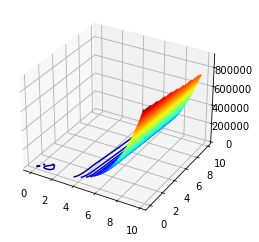

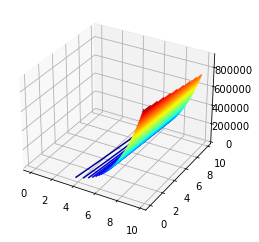

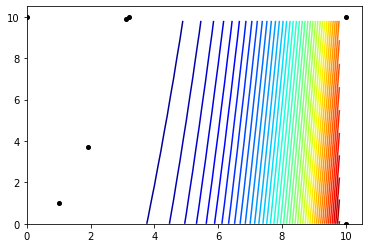

In [15]:
lb, ub, st = 0, upper, upper/50.
bounds = '{0}:{1}:{2}, {0}:{1}:{2}'.format(lb, ub, st)
bounds = "0:10:0.2, 0:10:0.2"
#bounds += ', 0.0'
# get learned model
try:
  f = mc.archive.read_func('func.db', n=0)[0]
  my.model_plotter(lambda x: f(*x), depth=True, bounds=bounds)
except:
  pass
# check truth model
objective = dill.load(open('cost.pkl', 'rb'))
my.model_plotter(objective, depth=True, bounds=bounds)

# get terminated points
extrema = mc.archive.read(ename)
em = my.monitors.Monitor()
if len(extrema):
  em._x, em._y = zip(*extrema.items())
  em._y = list(em._y)
  em._x = [list(x) for x in em._x]

my.model_plotter(objective, em, depth=False, bounds=bounds, dots=True, join=False)